# [LAB 12] 1.단순 선형 회귀

### #01. 회귀분석 개요

#### 1. 회귀 분석의 의미
- 하나 이상의 독립변수가 종속변수에 미치는 영향을 직선 형태로 표현한 것. 그 관계를 이용해 값을 예측하는 방법
- 독립변수들이 종속변수에 미치는 영향 추정
- 규명된 함수식을 이요하여 설명 변수들의 변화로부터 종속 변수의 변화 예측
- 독립변수 X 에 대하여 종속변수 Y 들 사이의 관계를 수학적 모형을 이용하여 규명


y=f(x) 일 때, 방정식을 규명하고, 독립적인 값 x 에 따라 y 가 어떻게 변화하는지 예측, 이를 통해 변수들 간의 인과관계를 밝히고, 모형을 적합하여 관심있는 변수를 예측하거나 추론하기 위한 분석 방법



#### 2. 회귀분석의 변수
- y : 영향을 받는 변수 (반응변수, 종속변수, 결과변수)
- x : 설명변수, 독립 변수


#### 3. 회귀분석의 종류
| 구분        | 모형                                      | 언제 사용하는가                          | 핵심 특징                                              | 예시                    |
|-------------|-------------------------------------------|-------------------------------------------|--------------------------------------------------------|-------------------------|
| 선형 회귀   | 단순선형회귀 (Simple Linear Regression)   | 하나의 X가 Y를 설명할 때                 | 직선 관계, 모델 해석 쉬움                               | 키 → 몸무게             |
|             | 다중선형회귀 (Multiple Linear Regression) | 여러 X가 Y에 영향을 줄 때                | 공선성 진단 필요, 계수 해석 중심                        | 집값 → 면적·연식·층수   |
| 비선형 확장 | 다항회귀 (Polynomial Regression)          | X–Y 관계가 곡선일 때                      | X², X³ 등 항 추가                                       | U자형 소비 패턴         |
| 분류형 결과 | 로지스틱 회귀 (Logistic Regression)        | Y가 0/1일 때 확률을 예측할 때             | 선형결합 → 시그모이드 변환                              | 이탈 여부, 합격 여부    |
| 시계열 분석 | ARIMA (AutoRegressive Integrated Moving Average) | 시간 흐름 속 추세·계절·패턴 예측   | AR(자기회귀) + I(차분) + MA(이동평균) 구조              | 월별 매출·수요 예측     |


### #02.준비작업
#### 1.패키지 참조

In [24]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, melt
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np


# 선형회귀를 위한 참조
from statsmodels.formula.api import ols


# 상관분석을 위한 참조
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

#### 2.그래프 초기화

In [25]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

#### 3.데이터 가져오기

In [26]:
origin = load_data ('cars')

print("\n===== 타입확인 =====")
print(origin.info())
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

origin.head()

[data] https://data.hossam.kr/data/lab12_/cars.xlsx
[desc] 자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리


===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   speed   50 non-null     int64
 1   dist    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None

===== 데이터 크기 확인 =====
데이터셋 크기: (50, 2)
열 개수: 2
행 개수: 50


,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


### #03. 탐색적 데이터 분석
#### 1.두 변수간의 관계 시각화

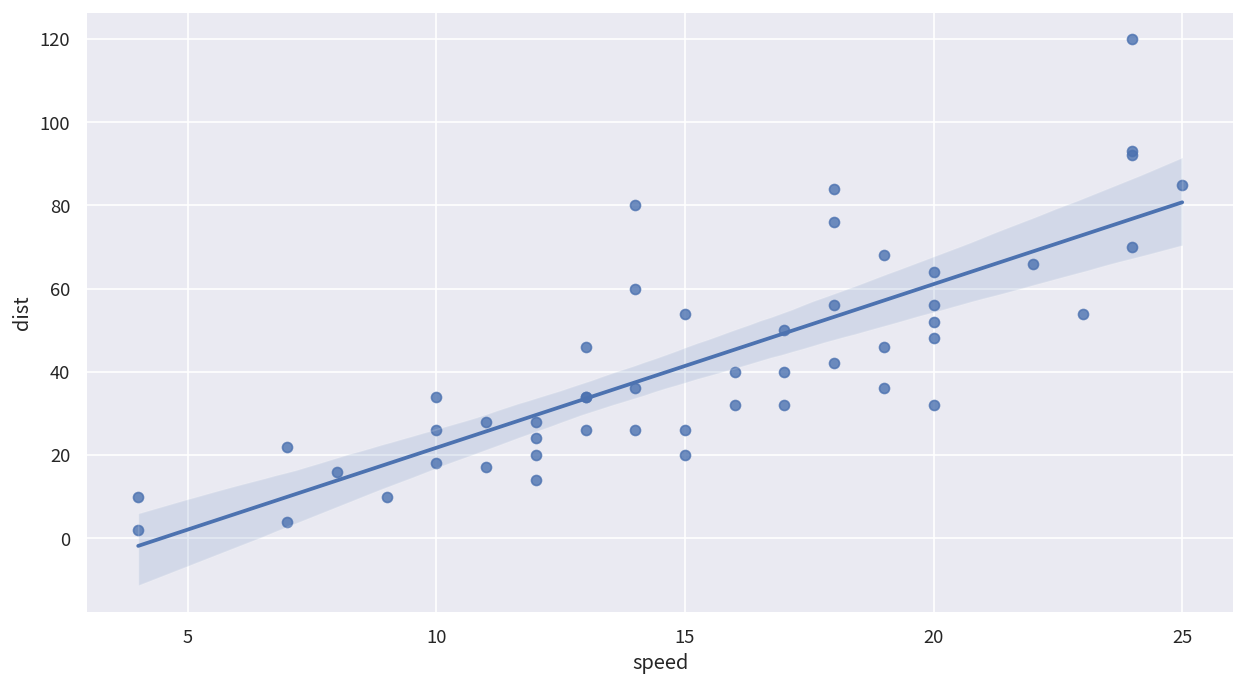

In [27]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.regplot(data=origin , x='speed',y='dist')

# 3) 그래프 꾸미기
ax.grid(True)                          # 배경 격자 표시/숨김

# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료



> 자동차 속도와 제동거리는 선형성을 충족하고 양의 상관관계가 있는 것으로 보인다

### #04. 추론통계
#### 1. 상관분석





=== 이상치 확인 ===
이상치 존재


,original_skew,log_skew,outliers(|z|>3)
speed,-0.117510,-1.668586,0.0
dist,0.806895,-1.384501,1.0


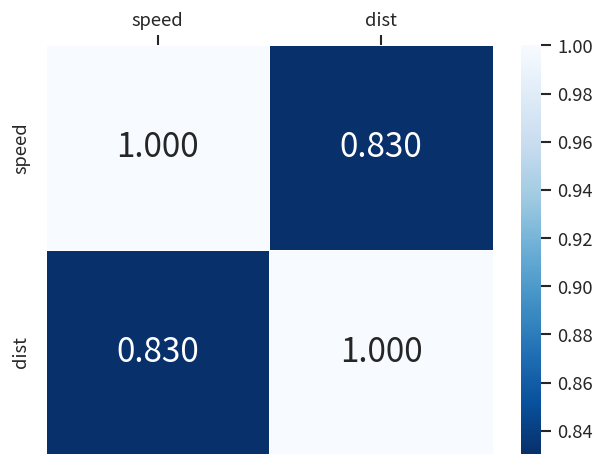

본 분석에서는 speed과 dist간 상관관계를 검토하였다.

데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.

분석 결과, 스피어만 상관계수는 r = 0.830, p = 0.000( ● )으로 나타나 두 변수 간 양의 단조 관계가 존재함을 확인하였다.


In [28]:
xname= 'speed'
yname = 'dist'


#선형성 가정 확인 > 간점도 그래프를 통해 시각적으로 확인
#선형성 적합 여부 (True=적합 , False = 부적합)

linearity_ok = True

#이상치와 왜도 검정

data = origin[[xname,yname]]


results ={}


for col in data.columns:
  temp=data[col].dropna()


  #왜도 계산
  skew_original = temp.skew()

  #z score 기반 이상치 탐지 |z| > 3
  z_scores = zscore(temp)
  outlier_count = int(np.sum(np.abs(z_scores) > 3))

  #로그 변환 후 왜도 계산 (음수 대비 +1)
  data_log = np.log1p(temp - temp.min() +1)
  skew_log = data_log.skew()


  results[col] = {
    'original_skew' : skew_original,
    'log_skew':skew_log,
    'outliers(|z|>3)':outlier_count


  }


results_df = DataFrame(results).T




# 이상치 점검 결과
outlier_flag = len(results_df[results_df['outliers(|z|>3)'] > 0]) > 0

print("\n=== 이상치 확인 ===")
print(f"{'이상치 존재' if outlier_flag else '이상치 존재하지 않음'}")
display(results_df)

# ----------------------------------------
# 상관분석
# ----------------------------------------
report = f"본 분석에서는 {xname}과 {yname}간 상관관계를 검토하였다.\n\n"

# 1. 상관계수 선택
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearsonr(origin[xname], origin[yname])
    
    if pval > 0.05:
        report += "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
    else:
        report += (
            "데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 "
            "피어슨 상관계수를 사용하였다.\n\n"
            f"분석 결과, 피어슨 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}"
            f"( {'⊙' if pval > 0.05 else '●'} )으로 나타나 두 변수 간 "
            f"{'양의 상관' if corr > 0 else '음의 상관'} 관계가 "
            "통계적으로 유의함을 확인하였다."
        )
else:
    chosen = 'spearman'
    corr, pval = spearmanr(origin[xname], origin[yname])
    
    if pval > 0.05:
        report += "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
    else:
        report += (
            "데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 "
            "스피어만 상관계수를 사용하였다.\n\n"
            f"분석 결과, 스피어만 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}"
            f"( {'⊙' if pval > 0.05 else '●'} )으로 나타나 두 변수 간 "
            f"{'양의 단조' if corr > 0 else '음의 단조'} 관계가 존재함을 확인하였다."
        )

# ----------------------------------------
# 결과 시각화
# ----------------------------------------
corr_matrix = origin[[xname, yname]].corr(method=chosen)

# 1) 그래프 초기화
width_px  = 650   # 그래프 가로 크기
height_px = 500   # 그래프 세로 크기
rows = 1          # 그래프 행 수
cols = 1          # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) heatmap 그리기
sb.heatmap(
    data=corr_matrix,
    annot=True,
    fmt="0.3f",
    linewidths=0.5,
    cmap="Blues_r",
    annot_kws={"size": 20}
)

# 3) 그래프 꾸미기
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()   # x축의 변수 이름을 상단으로 이동

# 4) 출력
plt.tight_layout()   # 여백 제거
plt.show()           # 그래프 화면 출력
plt.close()          # 그래프 작업 종료

# ----------------------------------------
# 결과 보고 출력
# ----------------------------------------
print(report)


#### 2.단순선형회귀

| 구분               | 내용                                                                 | 핵심 포인트                                                         |
|--------------------|----------------------------------------------------------------------|---------------------------------------------------------------------|
| 회귀를 수행하는 이유 | 상관은 단순히 두 변수의 동반 변화만 알려주므로, 관계를 **수식으로 정량화**하기 위해 회귀를 수행함 | β₁을 통해 “속도가 1 증가할 때 제동거리가 얼마나 증가하는지”를 추정 |
| 회귀의 목적        | 두 변수의 관계를 기반으로 **예측 모델을 구축**하고 실제 값을 예측 | 특정 속도에서 제동거리 예측, 미래 데이터 예측, 영향력 평가 |
| 요약               | 상관분석은 관계 존재 여부, 회귀는 **정량적 관계 + 예측** | 설명 + 예측 가능 |


1) 행렬기반 방식
   (머신러닝 코드와 비슷한 스타일)

- 독립변수 행렬 준비

In [29]:

X = origin [['speed']]
X.head()

,speed
0,4
1,4
2,7
3,7
4,8


- 종속변수는 Series 형태로 준비

In [30]:
y = origin['dist']
y.head()

0     2
1    10
2     4
3    22
4    16
Name: dist, dtype: int64

- 상수항 추가
  y = ax+b 형태가 기본형이므로 b 역할을 하기 위한 상수항을 추가해야한다.
  상수항이 없다면 절편이 0 으로 고정된 잘못된 모델이 만들어질 수 있다
  (대부분의 현실 데이터는 원점을 지나지 않으므로 절편은 필수적임)

In [31]:
X = sm.add_constant(x)
X.head()

,const,speed
0,1.0,4
1,1.0,4
2,1.0,7
3,1.0,7
4,1.0,8


- 회귀분석 수행

In [32]:
# OLS 모델 객체 생성
# -> 이 단계에서는 아직 학습 (FIT) 되지 않은 모형의 틀만 만들어짐

model = sm.OLS(y,X)


#모델 적합 (FIT)
# -> 데이터를 이용해 회귀계수를 추정하고, 모델을 완성하는 단계
fit = model.fit()


#적합된 모델 객체의 분석 결과 확인
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.49e-12
Time:                        11:25:47   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5791      6.758     -2.601      0.0

#### 2) formula API 방식
(상수항이 자동으로 추가되는 특징이 있음)

In [33]:
#학습 모델 객체 생성
model = ols('dist ~ speed',data=origin)

#모델 적합
fit = model.fit()

#분석 결과 확인
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.49e-12
Time:                        11:25:47   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.5791      6.758     -2.601      0.0

### #05.분석결과 해석 방법
상관분석은 단순히 관계 유무 여부를 알려준다면, 회귀분석에서는 그 관계를 수식으로 표현하고, 해당 모델이 얼마나 좋은 모델인지 평가해야한다
- 모델이 데이터를 잘 설명하고 있는가
- 예측력이 충분한가
- 다른 모델보다 더 좋은가
- 이 모델을 사용할 가치가 있는가

| 번호 | 항목명                          | 의미(설명)                                                     | dist ~ speed 모형에서의 해석                                                 |
| -- | ---------------------------- | ---------------------------------------------------------- | --------------------------------------------------------------------- |
| ①  | **R-squared (R², 결정계수)**     | 종속변수 변동을 독립변수가 얼마나 설명하는지 나타내는 지표. 0~1 사이 값. 높을수록 설명력↑      | **0.651 → speed가 dist의 변동 중 약 65.1%를 설명**. 단일 독립변수 모델임을 감안할 때 높은 설명력. |
| ②  | **Adj. R-squared (수정 결정계수)** | 변수 개수를 고려한 R² 보정값. 다중회귀에서 과대평가 방지를 위해 사용. 단순선형회귀에서는 R²와 동일 | **0.644 → speed 하나만으로도 충분한 설명력을 가지며, R²와 거의 동일**                      |
| ③  | **F-statistic (F 통계량)**      | 전체 회귀모형이 통계적으로 유의한지 검정                                     | **89.57 → 매우 큰 값. speed가 dist를 설명하는 데 중요한 역할을 한다는 의미**                |


| 번호 | 항목명                       | 의미(설명)                                                      | dist ~ speed 모형에서의 해석                                                    |
| -- | ------------------------- | ----------------------------------------------------------- | ------------------------------------------------------------------------ |
| ④  | **Prob(F-statistic)**     | F 검정의 p-value. 모형 전체 유의성 판단. p ≤ 0.05면 모형 유의                | **1.49e-12 (p < 0.001)** → 회귀모형 전체가 매우 유의. 즉, speed는 dist를 의미 있게 설명하는 변수 |
| ⑤  | **Log-Likelihood (로그우도)** | 모형이 데이터를 얼마나 잘 설명하는지 나타내는 우도 기반 지표. 단독 해석보다는 AIC/BIC 비교에 사용 | **-206.58 → 절대값 자체 의미는 크지 않고 AIC/BIC 비교용**                               |
| ⑥  | **AIC / BIC**             | 모형 선택 기준. 낮을수록 좋은 모델(복잡도 패널티 포함)                            | **AIC = 417.2, BIC = 421.0 → 비교 대상 모델이 없어서 단독 해석 의미는 없음**                |


2. 회귀계수 해석 (β₀ ~ β₁)

회귀계수는 독립변수가 종속변수에 미치는 영향을 수치로 표현한 값이며,
기울기는 변화량을, 절편은 직선의 기준점을 의미한다.

1) 절편 (β₀)

- X = 0일 때 Y의 값
- 직선의 시작점(Intercept) 을 결정
- 해석보다는 모델의 구조적 기준점 역할을 크게 한다

2) 기울기 (β₁, β₂, …)
- 독립변수가 1 증가할 때 종속변수가 얼마나 변하는지 나타내는 값
- 회귀분석에서 가장 중요한 부분
- 독립변수의 영향력 크기와 방향(+, -) 을 수치로 보여줌

| 번호 | 항목명                    | 의미(설명)                                             | dist ~ speed 모형에서의 해석                                                                          |
| -- | ---------------------- | -------------------------------------------------- | ---------------------------------------------------------------------------------------------- |
| ⑦  | **Intercept (절편, β₀)** | x=0일 때 y의 예상값. 회귀직선이 y축과 만나는 지점. <br>모델의 *출발점* 의미. | **-17.5791** → 속도가 0일 때 제동거리(dist)는 약 **-17.58**로 추정됨. <br>실제 물리적으로 의미는 부족하지만, 회귀선의 기준점 역할을 함. |







4) 회귀계수를 수식으로 정리

| 번호 | 항목명                | 의미(설명)                                                                                           | dist ~ speed 모형에서의 해석                                                                   |
| -- | ------------------ | ------------------------------------------------------------------------------------------------ | --------------------------------------------------------------------------------------- |
| ⑨  | **p-value (유의확률)** | 회귀계수가 0(효과 없음)이라는 귀무가설을 검정하는 값. <br>p ≤ 0.050이면 회귀계수가 **유의미하게 0이 아니다** → 독립변수가 종속변수에 영향을 준다는 의미. | **speed의 p값 = 0.000 → p < 0.001** 수준에서 매우 유의. <br>즉, **speed는 dist에 통계적으로 유의한 영향을 준다.** |


### #06. 회귀분석의 결과 보고
#### 1. 모형 적합도 보고
회귀모형이 통계적으로 유의한지 판단하기 위해 F 통계량, 자유도 ,P VALUE 그리고 설명력을 함께 보고한다


EX) dist 를 종속변수로, speed를 독립변수로 한 단순회귀분석 결과, 모형은 통계적으로 유의하였다.
F(1,48) = 89.57 , p < 0.001 , R² = 0.651
즉 ,SPEDD 는 DIST 의 약 65.1 % 를 설명하는 것으로 나타났다




#### 2. 독립변수 보고
독립변수가 종속변수에 유의미한 영향을 주는지 보고하기 위해
회귀변수 (β) , t 값, 자유도 (df) , p-value, 를 기술한다


EX) speed 의 회귀계수는 β =3.93 으로 나타났으며, 이는 dist 에 유의미하게 정(+) 적 영향을 미쳤다. t(48) = 9.46 p<0.001

즉 speed 가 1 증가할 떄 dist 는 평균적으로 3.93 증가하는 것으로 해석된다

### #07.실제 데이터와 모형의 예측값 비교
#### 1.모형 예측값 얻기
분석 모형에 x 에 해당하는 speed 를 넣어 y 에 해당하는 dist 가 계산된 값

In [34]:
df = origin.copy()
df['y_pred'] = fit.predict(X)
df.head()

,speed,dist,y_pred
0,4,2,-1.849460
1,4,10,-1.849460
2,7,4,9.947766
3,7,22,9.947766
4,8,16,13.880175


In [35]:
df_melt = df.melt(
  id_vars = 'speed',                      #speed 는 그대로
  value_vars = ['dist' , 'y_pred'],       # long 형태로 변환할 변수
  var_name = 'variable',                  # 명목형 변수명
  value_name = 'value'                    # 값 변수명
)


df_melt.head()

,speed,variable,value
0,4,dist,2.0
1,4,dist,10.0
2,7,dist,4.0
3,7,dist,22.0
4,8,dist,16.0


#### 2.시각화 비교


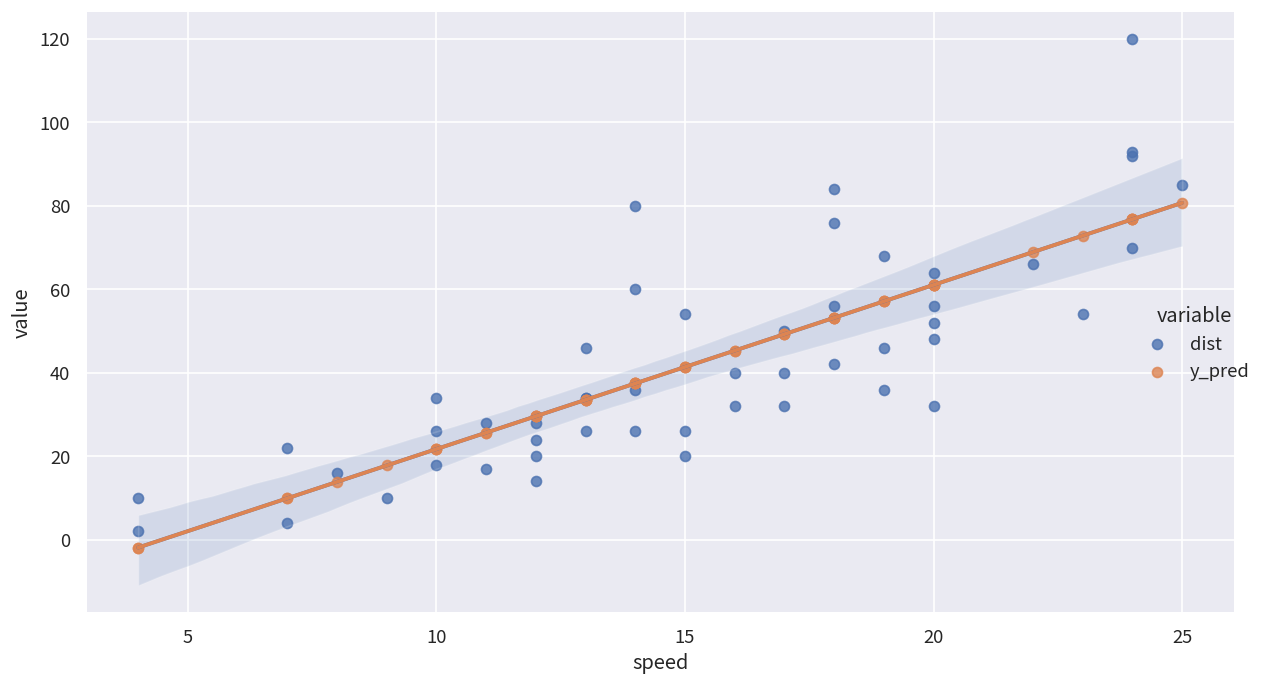

In [36]:
# 1) 그래프 초기화
width_px  = 1280                 # 그래프 가로 크기
height_px = 720                  # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# 2) LM Plot 그리기
g = sb.lmplot(data=df_melt, x='speed', y='value', hue='variable')
g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figheight(figsize[1])
plt.grid()

# 3) 출력
plt.tight_layout()               # 여백 제거
plt.show()                       # 그래프 화면 출력
plt.close()                      # 그래프 작업 종료
